# **Explorations in Churn**

This file utilizes a data set regarding voluntary customer churn in the telecom industry where customers are on some sort of contract involving international phone calling plans. The data set will be prepared for data analysis, exploratory data analysis will be performed and different types of models will be created including decision tree analysis, logistic regression, support vector classifier, and a random forest with optimized hyperparameters. The most influential features of the data set will be revealed.

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import lazypredict
import os
import lightgbm as lgb
import scipy
import time
import warnings
warnings.filterwarnings('ignore')
style.use('ggplot')
from google.colab import files
from scipy.stats import randint, loguniform
from sklearn import tree
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, f1_score
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from lazypredict.Supervised import LazyClassifier

Now, we will import the data

In [2]:
# necessary to read files into Colab
uploaded_files = files.upload()

Saving churn.csv to churn.csv


In [3]:
df = pd.read_csv('churn.csv')

You can find the churn data set that was used <a href="https://data.world/earino/churn">here</a>.

In [4]:
seed=2346

Below is a summary of columns, size and data types of the intital data set.

In [5]:
#Explore the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Account_Length  3333 non-null   int64  
 1   Vmail_Message   3333 non-null   int64  
 2   Day_Mins        3333 non-null   float64
 3   Eve_Mins        3333 non-null   float64
 4   Night_Mins      3333 non-null   float64
 5   Intl_Mins       3333 non-null   float64
 6   CustServ_Calls  3333 non-null   int64  
 7   Churn           3333 non-null   object 
 8   Intl_Plan       3333 non-null   object 
 9   Vmail_Plan      3333 non-null   object 
 10  Day_Calls       3333 non-null   int64  
 11  Day_Charge      3333 non-null   float64
 12  Eve_Calls       3333 non-null   int64  
 13  Eve_Charge      3333 non-null   float64
 14  Night_Calls     3333 non-null   int64  
 15  Night_Charge    3333 non-null   float64
 16  Intl_Calls      3333 non-null   int64  
 17  Intl_Charge     3333 non-null   f

Below is the first five rows of the intital data set showing all of the intital features.

In [6]:
df.head()

,Account_Length,Vmail_Message,Day_Mins,Eve_Mins,Night_Mins,Intl_Mins,CustServ_Calls,Churn,Intl_Plan,Vmail_Plan,Day_Calls,Day_Charge,Eve_Calls,Eve_Charge,Night_Calls,Night_Charge,Intl_Calls,Intl_Charge,State,Area_Code,Phone
0,128,25,265.10,197.40,244.70,10.00,1,no,no,yes,110,45.07,99,16.78,91,11.01,3,2.70,KS,415,382-4657
1,107,26,161.60,195.50,254.40,13.70,1,no,no,yes,123,27.47,103,16.62,103,11.45,3,3.70,OH,415,371-7191
2,137,0,243.40,121.20,162.60,12.20,0,no,no,no,114,41.38,110,10.30,104,7.32,5,3.29,NJ,415,358-1921
3,84,0,299.40,61.90,196.90,6.60,2,no,yes,no,71,50.90,88,5.26,89,8.86,7,1.78,OH,408,375-9999
4,75,0,166.70,148.30,186.90,10.10,3,no,yes,no,113,28.34,122,12.61,121,8.41,3,2.73,OK,415,330-6626


Wow, there are lot of features in this data set!  Let's see if we can get rid of some of them as we only have 3333 rows to work with. This tells us a great deal already as there are no missing values, our target has been identified as Churn, and there are some object variables that need to be converted.  Phone and Area Code can be dropped so let's do that now.

In [7]:
df = df.drop(['Area_Code', 'Phone'], axis = 1)

There are object columns that have to be converted to numeric for modeling unless we want to use a decision tree. Single trees are great for EDA and visualization but have poor predictive power. One of these values is the State variable. Let's take a look at it to see if this could be a relative variable. One-hot encoding is not an option here.

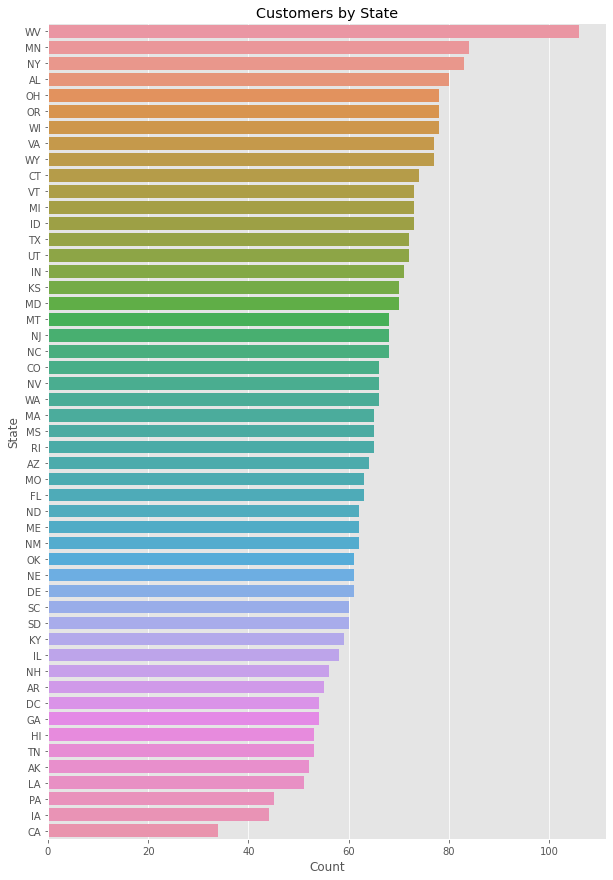

In [8]:
plt.figure(figsize=(10,15))

sns.countplot(y = 'State', data = df, order=df.State.value_counts().index)
plt.title('Customers by State')
plt.xlabel('Count')

plt.show()

There does seem to be some variability by state but no real trend per region.  We will drop the state variable as well.  Let's see about the percentage of churn vs. no churn. If the percentage is below 5% then we may have an overfitting problem.

In [9]:
print(df.groupby(['Churn']).size() / df.shape[0] * 100)

Churn
no    85.51
yes   14.49
dtype: float64


Only around 14% of the samples have churned which is not ideal but we should be able to model the data. We may have to stratify the train and test split here. Before we convert the categorical variables, let's do some feature engineering because there are some columns that may need to be combined or eliminated. The International, daytime, night time and evening call minutes can be divided by their respective total calls for average call minutes per call and let's check the columns/indexes.

In [10]:
df['Avg_Day_Calls'] = df['Day_Mins'] / df['Day_Calls']
df['Avg_Eve_Calls'] = df['Eve_Mins'] / df['Eve_Calls']
df['Avg_Intl_Calls'] = df['Intl_Mins'] / df['Intl_Calls']
df['Avg_Night_Calls'] = df['Night_Mins'] / df['Night_Calls']

#And let's check the columns/indexes

print(df.columns)

Index(['Account_Length', 'Vmail_Message', 'Day_Mins', 'Eve_Mins', 'Night_Mins',
       'Intl_Mins', 'CustServ_Calls', 'Churn', 'Intl_Plan', 'Vmail_Plan',
       'Day_Calls', 'Day_Charge', 'Eve_Calls', 'Eve_Charge', 'Night_Calls',
       'Night_Charge', 'Intl_Calls', 'Intl_Charge', 'State', 'Avg_Day_Calls',
       'Avg_Eve_Calls', 'Avg_Intl_Calls', 'Avg_Night_Calls'],
      dtype='object')


Now, we can create a new dataframe with the previous features dropped by subetting. That way if there is an error, we can revert back to the original df.

In [11]:
df_new = df[['Account_Length', 'Vmail_Message', 'CustServ_Calls', 'Churn', 'Intl_Plan', 'Vmail_Plan', 'Day_Charge', 'Eve_Charge',
       'Night_Charge', 'Intl_Charge', 'State', 'Avg_Day_Calls',
       'Avg_Eve_Calls', 'Avg_Intl_Calls', 'Avg_Night_Calls' ]]
df_new.head()

,Account_Length,Vmail_Message,CustServ_Calls,Churn,Intl_Plan,Vmail_Plan,Day_Charge,Eve_Charge,Night_Charge,Intl_Charge,State,Avg_Day_Calls,Avg_Eve_Calls,Avg_Intl_Calls,Avg_Night_Calls
0,128,25,1,no,no,yes,45.07,16.78,11.01,2.70,KS,2.41,1.99,3.33,2.69
1,107,26,1,no,no,yes,27.47,16.62,11.45,3.70,OH,1.31,1.90,4.57,2.47
2,137,0,0,no,no,no,41.38,10.30,7.32,3.29,NJ,2.14,1.10,2.44,1.56
3,84,0,2,no,yes,no,50.90,5.26,8.86,1.78,OH,4.22,0.70,0.94,2.21
4,75,0,3,no,yes,no,28.34,12.61,8.41,2.73,OK,1.48,1.22,3.37,1.54


Looking good, now for exploratory data analysis (EDA).

### **Exploratory Data Analysis**

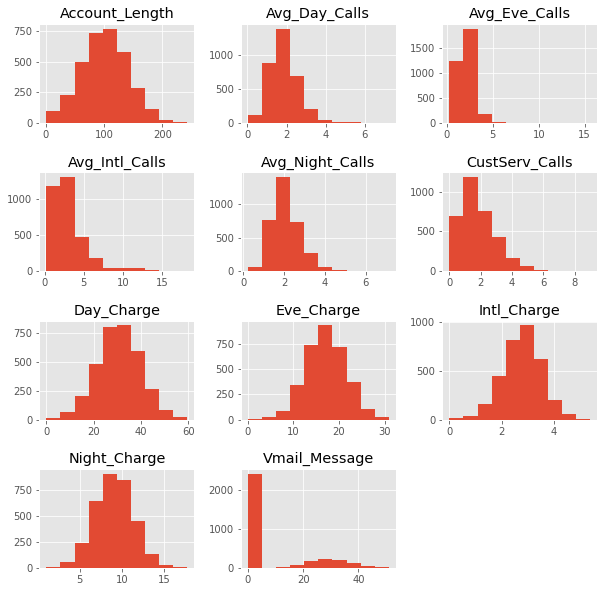

In [12]:
df_new.hist(figsize=(10,10))
plt.subplots_adjust(hspace=0.5);

Some of these values have a normal distribution but some are skewed, namely our new features. Voicemail messages appear more categorical but let's check if they are relevant to the target first. We will need to standardize the numerical variabes.

In [13]:
print(df_new.nunique())

Account_Length      212
Vmail_Message        46
CustServ_Calls       10
Churn                 2
Intl_Plan             2
Vmail_Plan            2
Day_Charge         1667
Eve_Charge         1440
Night_Charge        933
Intl_Charge         162
State                51
Avg_Day_Calls      3259
Avg_Eve_Calls      3253
Avg_Intl_Calls      781
Avg_Night_Calls    3244
dtype: int64


Essentially, what we see here is that Intl_Plan, Vmail_Plan and State are our categorical variables. Churn is our target and should be removed before modeling. First, the numerical fields will be standardized or scaled using StandardScaler by removing the categorical variables. For now, the target will remain so we can run a Decision Tree model.

In [14]:
#Separating categorical and numeric variables.
state = ['State']
cat = df_new.nunique()[df_new.nunique() < 3].keys().tolist()
numerical = [x for x in df_new.columns if x not in cat + state]

In [15]:
#Here, we will scale the numerical data.

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_new[numerical])
df_scaled = pd.DataFrame(df_scaled, columns=numerical)

We will merge categorical and numerical variables back together in a final dataframe and make categorical variables binary. The state data will be omitted as the previous graph shows only limited variability.

In [16]:
categorical = df_new[['Churn', 'Intl_Plan', 'Vmail_Plan']]
dff = pd.concat([categorical, df_scaled], axis = 1)
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Churn            3333 non-null   object 
 1   Intl_Plan        3333 non-null   object 
 2   Vmail_Plan       3333 non-null   object 
 3   Account_Length   3333 non-null   float64
 4   Vmail_Message    3333 non-null   float64
 5   CustServ_Calls   3333 non-null   float64
 6   Day_Charge       3333 non-null   float64
 7   Eve_Charge       3333 non-null   float64
 8   Night_Charge     3333 non-null   float64
 9   Intl_Charge      3333 non-null   float64
 10  Avg_Day_Calls    3331 non-null   float64
 11  Avg_Eve_Calls    3332 non-null   float64
 12  Avg_Intl_Calls   3315 non-null   float64
 13  Avg_Night_Calls  3333 non-null   float64
dtypes: float64(11), object(3)
memory usage: 364.7+ KB


The data set is now ready for modeling.  Now we will convert our categorical variables and our target into binary variables and call a Decision Tree for EDA.

In [17]:
dff['Vmail_Plan'] = dff['Vmail_Plan'].replace({'no':0, 'yes':1})
dff['Intl_Plan'] = dff['Intl_Plan'].replace({'no':0, 'yes':1})
dff['Churn'] = dff['Churn'].replace({'no':0, 'yes':1})

In [18]:
#Checking the data with head() to ensure that we are ready for modeling.
dff.head()

,Churn,Intl_Plan,Vmail_Plan,Account_Length,Vmail_Message,CustServ_Calls,Day_Charge,Eve_Charge,Night_Charge,Intl_Charge,Avg_Day_Calls,Avg_Eve_Calls,Avg_Intl_Calls,Avg_Night_Calls
0,0,0,1,0.68,1.23,-0.43,1.57,-0.07,0.87,-0.09,0.73,-0.14,0.10,0.84
1,0,0,1,0.15,1.31,-0.43,-0.33,-0.11,1.06,1.24,-0.76,-0.27,0.64,0.53
2,0,0,0,0.90,-0.59,-1.19,1.17,-1.57,-0.76,0.70,0.36,-1.29,-0.30,-0.74
3,0,1,0,-0.43,-0.59,0.33,2.20,-2.74,-0.08,-1.31,3.21,-1.81,-0.96,0.17
4,0,1,0,-0.65,-0.59,1.09,-0.24,-1.04,-0.28,-0.05,-0.54,-1.15,0.11,-0.77


Now, we will define our target as X and the rest of dff as y and run a decision tree. This will be used for plotting and visualization as opposed to assessing model performance. We will try a test size of 1/4 and check the split. 

In [19]:
y = dff['Churn']
X = dff.drop(['Churn'], axis=1)

X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.mean(), inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=seed)
print(X_train.shape[0] / X.shape[0])
print(X_test.shape[0] / X.shape[0])

0.7497749774977498
0.2502250225022502


Looks like the kind of training and test split that we want.  Let's see what kind of tree we can get and what features the tree displays as important.

In [20]:
clf = tree.DecisionTreeClassifier(max_depth = 7, criterion = 'gini', splitter = 'best')
modelT = clf.fit(X_train, y_train)
pred_y = modelT.predict(X_test)
print("Training accuracy: ", np.round(clf.score(X_train, y_train), 3))
print("Test accuracy: ", np.round(accuracy_score(y_test, pred_y), 3))

Training accuracy:  0.972
Test accuracy:  0.929


Wow, that is an awesome test accuracy!  Let's check precision and recall.

In [21]:
test_precision = round(precision_score(y_test, pred_y), 4)
test_recall = round(recall_score(y_test, pred_y), 4)
print('Test precision: {}, Test recall: {}'.format(test_precision, test_recall))

Test precision: 0.8163, Test recall: 0.6612


That is a pretty good precision and recall.  Let's optimize the tree first.

In [22]:
depth_list = list(range(2, 15))
depth_tuning = np.zeros((len(depth_list), 4))
depth_tuning[:,0] = depth_list
for index in range(len(depth_list)):
    clf = DecisionTreeClassifier(max_depth=depth_list[index])
    clf.fit(X_train, y_train)
    pred_y = clf.predict(X_test)
    depth_tuning[index,1] = accuracy_score(y_test, pred_y)
    depth_tuning[index,2] = precision_score(y_test, pred_y)
    depth_tuning[index,3] = recall_score(y_test, pred_y)
col_names = ['Max_Depth', 'Accuracy', 'Precision', 'Recall']
print(pd.DataFrame(depth_tuning, columns=col_names))

    Max_Depth  Accuracy  Precision  Recall
0        2.00      0.87       0.69    0.18
1        3.00      0.88       0.69    0.36
2        4.00      0.92       0.88    0.49
3        5.00      0.93       0.84    0.64
4        6.00      0.94       0.86    0.68
5        7.00      0.93       0.80    0.69
6        8.00      0.93       0.78    0.68
7        9.00      0.93       0.80    0.69
8       10.00      0.92       0.77    0.69
9       11.00      0.93       0.79    0.69
10      12.00      0.93       0.80    0.69
11      13.00      0.92       0.75    0.70
12      14.00      0.92       0.74    0.69


We can see that somewhere between 3 and 8 is advantageous. Let's try a tree depth of 3. Next, we will determine which features the decision tree finds to be most influential and plot the tree.

[Text(697.5, 951.3000000000001, 'Vmail_Message <= 1.473\ngini = 0.248\nsamples = 2499\nvalue = [2137, 362]'),
 Text(348.75, 679.5, 'CustServ_Calls <= 1.228\ngini = 0.198\nsamples = 2294\nvalue = [2038, 256]'),
 Text(174.375, 407.70000000000005, 'Churn <= 0.5\ngini = 0.132\nsamples = 2049\nvalue = [1903, 146]'),
 Text(87.1875, 135.89999999999998, 'gini = 0.082\nsamples = 1866\nvalue = [1786, 80]'),
 Text(261.5625, 135.89999999999998, 'gini = 0.461\nsamples = 183\nvalue = [117, 66]'),
 Text(523.125, 407.70000000000005, 'Day_Charge <= 0.068\ngini = 0.495\nsamples = 245\nvalue = [135, 110]'),
 Text(435.9375, 135.89999999999998, 'gini = 0.322\nsamples = 124\nvalue = [99, 25]'),
 Text(610.3125, 135.89999999999998, 'gini = 0.418\nsamples = 121\nvalue = [36, 85]'),
 Text(1046.25, 679.5, 'CustServ_Calls <= -0.1\ngini = 0.499\nsamples = 205\nvalue = [99, 106]'),
 Text(871.875, 407.70000000000005, 'Day_Charge <= 0.637\ngini = 0.303\nsamples = 102\nvalue = [19, 83]'),
 Text(784.6875, 135.899999999

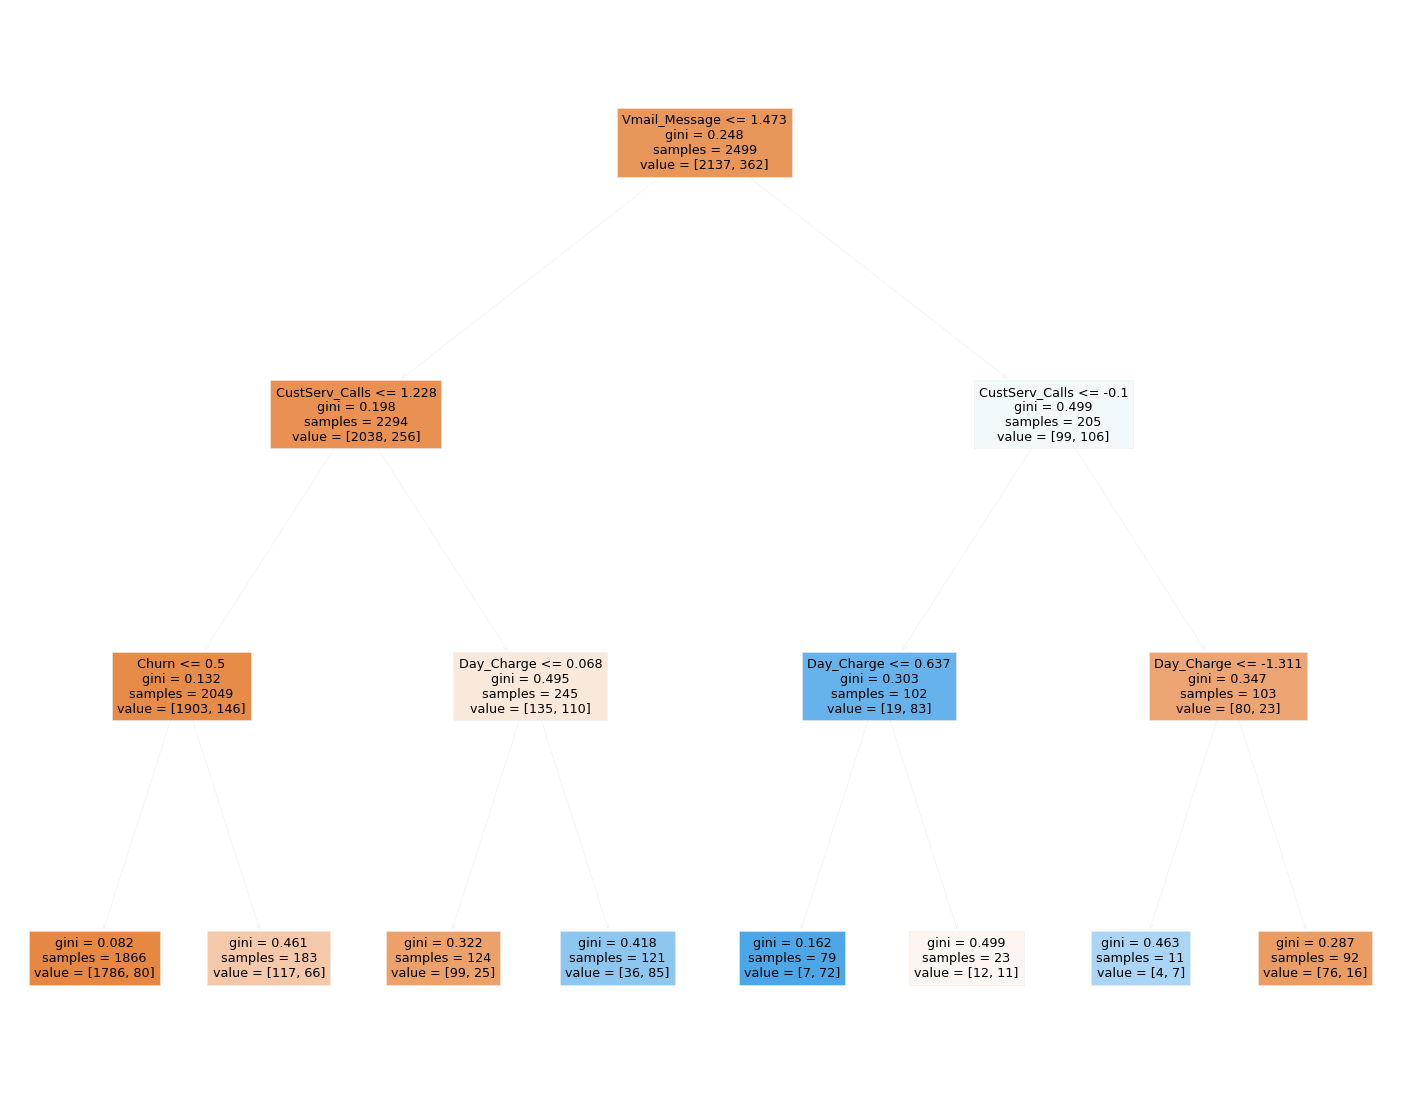

In [23]:
clf = tree.DecisionTreeClassifier(max_depth = 3, criterion = 'gini', splitter = 'best')
modelT = clf.fit(X_train, y_train)
fig = plt.figure(figsize=(25,20))
tree.plot_tree(clf, feature_names = ['Churn', 'Intl_Plan', 'Vmail_Plan', 'Account_Length', 'Vmail_Message', 'CustServ_Calls', 'Day_Charge', 'Eve_Charge',
       'Night_Charge', 'Intl_Charge', 'Avg_Day_Calls',
       'Avg_Eve_Calls', 'Avg_Intl_Calls', 'Avg_Night_Calls'], filled=True)

It looks like the tree split on voice mail messages first and then on customer service calls and daytime charges. This is only one tree though so other models will be explored but it is good to take a first look. On to modeling and the lazy predict classifier that will tell us what machine learning algorithms to consider.  From there, we can determine where we can use information to determine best features.

### **Modeling**

In [24]:
lazy = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = lazy.fit(X_train, X_test, y_train, y_test)

models

100%|██████████| 29/29 [00:04<00:00,  6.84it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.97,0.90,0.90,0.96,0.17
XGBClassifier,0.96,0.88,0.88,0.96,0.28
RandomForestClassifier,0.96,0.86,0.86,0.96,0.67
BaggingClassifier,0.95,0.86,0.86,0.95,0.20
DecisionTreeClassifier,0.91,0.82,0.82,0.91,0.07
SVC,0.93,0.76,0.76,0.92,0.19
ExtraTreesClassifier,0.93,0.76,0.76,0.92,0.31
NearestCentroid,0.75,0.75,0.75,0.78,0.02
ExtraTreeClassifier,0.87,0.74,0.74,0.87,0.02


While I actually guessed quite well that a decision tree would be good for this data, the Light Gradient Boosting Machine Classifier and Xtreme Gradient Boosting Classifier appear to have the highest accuracy AND the highest F1 score which is more important.  We will go with the Light Gradient Boosting Machine Classifier since our data set is small and it fit a little bit faster than XGBClassifier. First, we will define our hyperparameter tune function.

In [25]:
def hyperparameter_tune(base_model, parameters, n_iter, k, X=X_train, y=y_train):
    start_time = time.time()
    
    optimal_model = RandomizedSearchCV(base_model,
                            param_distributions=parameters,
                            n_iter=n_iter,
                            cv=k,
                            n_jobs=-1,
                            random_state=seed)
    
    optimal_model.fit(X, y)
    
    stop_time = time.time()

    scores = cross_val_score(optimal_model, X, y, cv=k, scoring="accuracy")
    
    print("Elapsed Time:", time.strftime("%H:%M:%S", time.gmtime(stop_time - start_time)))
    print("====================")
    print("Cross Val Mean: {:.3f}, Cross Val Stdev: {:.3f}".format(scores.mean(), scores.std()))
    print("Best Score: {:.3f}".format(optimal_model.best_score_))
    print("Best Parameters: {}".format(optimal_model.best_params_))
    
    return optimal_model.best_params_, optimal_model.best_score_

Now, we will define relevant hyperparameters for the LGBM classifier.

In [27]:
parameters = {
        'silent': [False],
        'max_depth': randint(3, 20),
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0, 3],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'num_leaves': randint(15, 60),
        'reg_lambda': loguniform(0.1, 100),
        'n_estimators': randint(50, 300)
}

Next, we will fit our Light Gradient Boosting Machine Classifier (LGBM) on the training set.

In [32]:
ltgb = lgb.LGBMClassifier(learning_rate=0.01, n_estimators=100, max_depth=15,subsample=0.52,colsample_bytree=0.6,seed=seed, 
                    reg_lambda=2, min_child_weight = 0.5, num_leaves=40)

best_params, best_score = hyperparameter_tune(ltgb, parameters, 60, 5, X_train, y_train)

Elapsed Time: 00:00:16
Cross Val Mean: 0.945, Cross Val Stdev: 0.006
Best Score: 0.946
Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 12, 'min_child_weight': 0.5, 'n_estimators': 73, 'num_leaves': 56, 'reg_lambda': 14.491658943324579, 'silent': False, 'subsample': 1.0}


Here, we will use the best hyperparameter values after 60 iterations which should put us inside of a 95% confidence interval that we have the best model and to put those hyperparameters into the model.  

In [33]:
ltgb_tuned = lgb.LGBMClassifier(learning_rate=0.2, n_estimators=73, max_depth=12, subsample=1,colsample_bytree=0.9,seed=seed, 
                    reg_lambda=14.491658943324579, min_child_weight = 0.5, num_leaves=56)
ltgb_tuned.fit(X_train,y_train)
print(ltgb_tuned.score(X_train,y_train))
print(ltgb_tuned.score(X_test,y_test))


0.9815926370548219
0.9664268585131894


Wow, that is a high accuracy on the training set and the test set and our y values have already been stratified.  

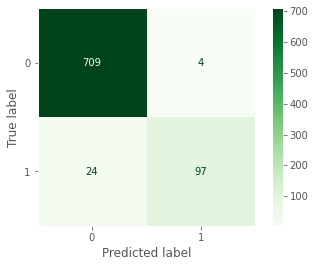

Accuracy of Light Gradient Boosting Machine: 96.64268585131894 

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       713
           1       0.96      0.80      0.87       121

    accuracy                           0.97       834
   macro avg       0.96      0.90      0.93       834
weighted avg       0.97      0.97      0.97       834



In [34]:
ltgb_predicted = ltgb_tuned.predict(X_test)

plot_confusion_matrix(ltgb_tuned, X_test, y_test, cmap = 'Greens')
plt.grid(False)
plt.show()

ltgb_acc_score = accuracy_score(y_test, ltgb_predicted)

print("Accuracy of Light Gradient Boosting Machine:",ltgb_acc_score*100,'\n')
print(classification_report(y_test,ltgb_predicted))

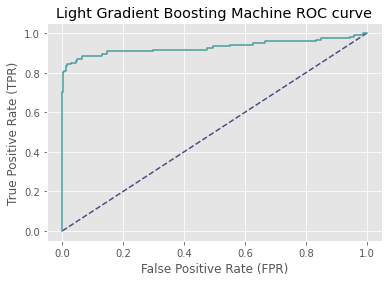

In [35]:
y_pred_proba = ltgb_tuned.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.plot([0,1],[0,1], color='#495084', linestyle='--')
plt.plot(fpr,tpr, label='ltgb', color='#479D9E')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Light Gradient Boosting Machine ROC curve')
plt.show()

In [36]:
roc = roc_auc_score(y_test,y_pred_proba)
print('ROC Score: {:.2f}'.format(roc))

ROC Score: 0.93


The scores are excellent as the area under the ROC curve is 0.93 and the final f1 score id 0.93 for the model.  Only 4 false negatives for this model! One last thing to do is to check for feature importances to see which of these features was most important to this model.

In [38]:
def plot_feature_importance(importance, names, model_type):

#Create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)

#Create a DataFrame using a Dictionary
  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)

#Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

#Define size of bar plot
  plt.figure(figsize=(10,8))
#Plot Searborn bar chart
  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
#Add chart labels
  plt.title(model_type + ' Feature Importance')
  plt.xlabel('Feature Importance to Model')
  plt.ylabel('Features')

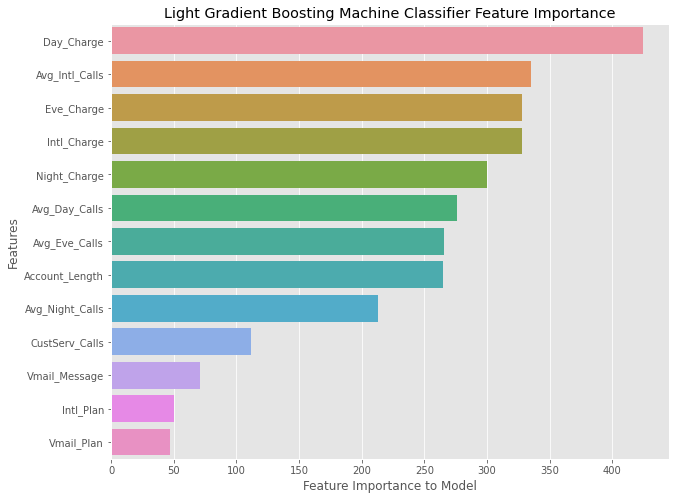

In [39]:
plot_feature_importance(ltgb_tuned.feature_importances_, X_train.columns,'Light Gradient Boosting Machine Classifier')

# **Conclusion**

Now that looks like a pretty robust model to me.  It is clear that charges are the primary indicator of customer churn in this telecom data set, in addition to the number of average international calls made.  Day charges are the most important feature to consider regarding churn.  One would suspect that customer service calls or voicemail messages left would be indicators of churn but not in this model.  The metrics for the LGBM model were astounding with 0.93 f1 score and a 0.93 area under the ROC curve, not to mention a 96% accuracy.  Lazy predict helped identify the best model and the model was utilized to provide excellent insight.